In [1]:
%matplotlib widget
%matplotlib inline
import torch
import torch.nn as nn
import pickle
import time
import copy
import os
from queue import LifoQueue
from sklearn.cluster import DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.metrics import davies_bouldin_score
from scipy.stats import kurtosis
import matplotlib.pyplot as plt
import numpy as np
import sys
from sklearn.tree import DecisionTreeClassifier
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from tqdm.notebook import tqdm
from sklearn.metrics import pairwise_distances
import network.cpc
from network.cpc import CDCK2
from utils.MatplotlibUtils import reduce_dims_and_plot
from utils.ClassificationUtiols import onehot_coding
from soft_decision_tree.sdt_model import SDT
from sklearn import tree as tt

# IPython.OutputArea.auto_scroll_threshold = 9999;

# Load the model and the dataset

In [2]:
model_path = r'/home/eitan.k/EntangledExplainableClustering/knn_loss_batch_512_k_16/models/epoch_28.pt'
dataset_path = r'/home/eitan.k/EntangledExplainableClustering/knn_loss_batch_512_k_16/data/test_data.file'

print(f"Load the model from: {model_path}")
model = torch.load(model_path, map_location='cpu')

with open(dataset_path, 'rb') as fp:
    dataset = pickle.load(fp)

all_sensors = dataset.dataset.all_signals    
print(f"sensor names: ({len(all_sensors)} total)")

for s in all_sensors:
    print(f"- {s}")
    
print(f"Multihorizon size of the model: {model.timestep}")
print(f"Test split ratio: {len(dataset) / len(dataset.dataset)}")
print(f"Total number of windows in the dataset (without splitting): {len(dataset.dataset)}")

Load the model from: /home/eitan.k/EntangledExplainableClustering/knn_loss_batch_512_k_16/models/epoch_28.pt
sensor names: (18 total)
- speed
- steering_angle
- wheel_speed_0
- wheel_speed_1
- wheel_speed_2
- wheel_speed_3
- accelerometer_0
- accelerometer_1
- accelerometer_2
- gyro_0
- gyro_1
- gyro_2
- gyro_bias_0
- gyro_bias_1
- gyro_bias_2
- gyro_uncalibrated_0
- gyro_uncalibrated_1
- gyro_uncalibrated_2
Multihorizon size of the model: 30
Test split ratio: 0.2
Total number of windows in the dataset (without splitting): 101465


In [3]:
batch_size = 500
loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=False)

# Extract representations

In [4]:
projections = torch.tensor([])
samples = torch.tensor([])
device = 'cuda'
model = model.to(device).eval()

with torch.no_grad():
    bar = tqdm(total=len(loader.dataset))
    for batch in loader:
        hidden = CDCK2.init_hidden(len(batch))
        batch = batch.to(device)
        hidden = hidden.to(device)

        y = model.predict(batch, hidden).detach().cpu()
        projections = torch.cat([projections, y.detach().cpu()])
        samples = torch.cat([samples, batch.detach().cpu()])
        bar.update(y.shape[0])

  0%|          | 0/20293 [00:00<?, ?it/s]

# Fit GMM and calculate indices

In [5]:
scores = []
best_score = float('inf')
clusters = None
range_ = list(range(5, 80))
for k in tqdm(range_):
    y = GaussianMixture(n_components=k).fit_predict(projections)
    cur_score = davies_bouldin_score(projections, y)
    scores.append(cur_score)
    
    if cur_score < best_score:
        best_score = cur_score
        clusters = y

  0%|          | 0/75 [00:00<?, ?it/s]

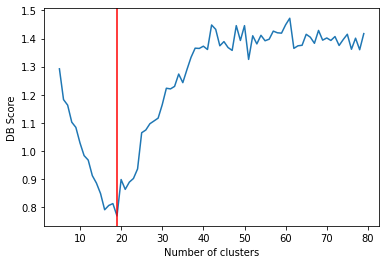

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18}


In [6]:
plt.figure()
plt.xlabel('Number of clusters')
plt.ylabel('DB Score')
plt.plot(range_, scores)
best_k = range_[np.argmin(scores)]
plt.axvline(best_k, color='r')
plt.show()

labels = set(clusters)
print(labels)

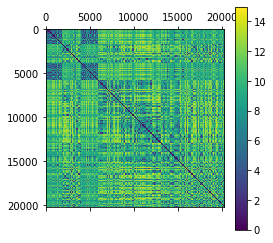

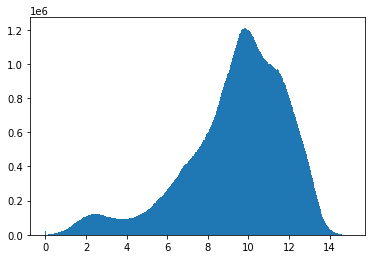

In [7]:
distances = pairwise_distances(projections)
# distances = np.triu(distances)
distances_f = distances.flatten()

plt.matshow(distances)
plt.colorbar()
plt.figure()
plt.hist(distances_f[distances_f > 0], bins=1000)
plt.show()

# Visualize with T-SNE

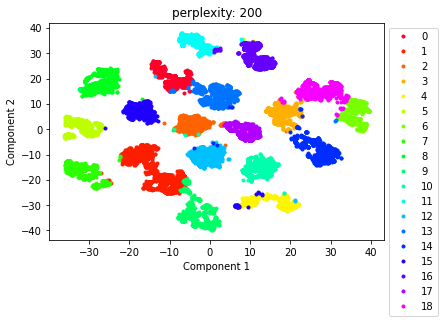

In [8]:
perplexity = 200

p = reduce_dims_and_plot(projections,
                         y=clusters,
                         title=f'perplexity: {perplexity}',
                         file_name=None,
                         perplexity=perplexity,
                         library='Multicore-TSNE',
                         perform_PCA=False,
                         projected=None,
                         figure_type='2d',
                         show_figure=True,
                         close_figure=False,
                         text=None)    

# Train a Soft-Decision-Tree given the self-labels

## Prepare the dataset

In [9]:
# unnormalized_samples = samples.clone()

# for col, sensor in enumerate(tqdm(dataset.dataset.all_signals)):
#     denormalizer = dataset.dataset.get_denormalization_for_sensor(sensor)
#     unnormalized_samples[:, col, :] = denormalizer(unnormalized_samples[:, col, :])

sampled = samples[..., range(0, samples.shape[-1], 200)]

samples_f = sampled.flatten(1)
tree_dataset = list(zip(samples_f, clusters))
batch_size = 2000
tree_loader = torch.utils.data.DataLoader(tree_dataset, batch_size=batch_size, shuffle=True)

# Define how we prune the weights of a node

In [10]:
def prune_node(node_weights, factor=1):
    w = node_weights.cpu().detach().numpy()
    mean_ = np.mean(w)
    std_ = np.std(w)
    node_weights[((mean_ - std_ * factor) < node_weights) & (node_weights < (mean_ + std_ * factor))] = 0
    return node_weights

def prune_node_keep(node_weights, keep=4):
    w = node_weights.cpu().detach().numpy()
    throw_idx = np.argsort(abs(w))[:-keep]
    node_weights[throw_idx] = 0
    return node_weights

def prune_tree(tree_, factor):
    new_weights = tree_.inner_nodes.weight.clone()
    for i in range(new_weights.shape[0]):
        res = prune_node_keep(new_weights[i, :], factor)
        new_weights[i, :] = res

    with torch.no_grad():
        tree_.inner_nodes.weight.copy_(new_weights)
        
def sparseness(x):
    s = []
    for i in range(x.shape[0]):
        x_ = x[i, :]
        sp = (len(x_) - torch.norm(x_, 0).item()) / len(x_)
        s.append(sp)
    return np.mean(s)

def compute_regularization_by_level(tree):
    total_reg = 0
    for i in range(tree.inner_nodes.weight.shape[0]):
        cur_level = np.floor(np.log2(i+1))
        node_reg = torch.norm(tree.inner_nodes.weight[i].view(-1), 2)
        total_reg += 2**(-cur_level) * node_reg
    return total_reg

def show_sparseness(tree):
    avg_sp = sparseness(tree.inner_nodes.weight)
    print(f"Average sparseness: {avg_sp}")
    layer = 0
    sps = []
    for i in range(tree.inner_nodes.weight.shape[0]):
        cur_layer = int(np.floor(np.log2(i+1)))
        if cur_layer != layer:
            print(f"layer {layer}: {np.mean(sps)}")
            sps = []
            layer = cur_layer

        x_ = tree.inner_nodes.weight[i, :]
        sp = (len(x_) - torch.norm(x_, 0).item()) / len(x_)
        sps.append(sp)
        
    return avg_sp

## Training configurations

In [11]:
def do_epoch(model, loader, device, log_interval, losses, accs, epoch, iteration):
    model = model.train()
    for batch_idx, (data, target) in enumerate(loader):
        iteration += 1
        data, target = data.to(device), target.to(device)

        output, penalty = tree.forward(data)

        # Loss
        loss_tree = criterion(output, target.view(-1))

        # Penalty
        loss_tree += penalty

        # Sparse regularization
#         fc_params = torch.cat([x.view(-1) for x in tree.inner_nodes.parameters()])
#         regularization = sparsity_lamda * torch.norm(fc_params, 2)
        regularization = sparsity_lamda * compute_regularization_by_level(tree)
        loss = loss_tree

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        losses.append(loss.item())

        pred = output.data.max(1)[1]
        correct = pred.eq(target.view(-1).data).sum()
        accs.append(correct.item() / data.size()[0])

        # Print training status
        if batch_idx % log_interval == 0:
            print(f"Epoch: {epoch:02d} | Batch: {batch_idx:03d} / {len(loader):03d} | Total loss: {loss.item():.3f} | Reg loss: {regularization.item():.3f} | Tree loss: {loss_tree.item():.3f} | Accuracy: {correct.item() / data.size()[0]:03f} | {round((time.time() - start_time) / iteration, 3)} sec/iter")
            
    return iteration


In [12]:
lr = 5e-3
weight_decay = 5e-4
sparsity_lamda = 2e-3
epochs = 500
output_dim = len(set(clusters))
log_interval = 1
tree_depth = 12

In [13]:
tree = SDT(input_dim=samples_f.shape[1], output_dim=len(labels), depth=tree_depth, lamda=1e-3, use_cuda=True)
optimizer = torch.optim.Adam(tree.parameters(),
                                 lr=lr,
                                 weight_decay=weight_decay)
criterion = nn.CrossEntropyLoss()
tree = tree.to(device)
clf = DecisionTreeClassifier(max_depth=tree_depth).fit(samples_f, clusters)
print(f"DT accuracy: {clf.score(samples_f, clusters)}")
tree.initialize_from_decision_tree(clf)

DT accuracy: 0.9956635292958163


In [14]:
losses = []
accs = []
sparsity = []

In [ ]:
start_time = time.time()
iteration = 0
for epoch in range(epochs):
    # Training
    avg_sp = show_sparseness(tree)
    sparsity.append(avg_sp)
    iteration = do_epoch(tree, tree_loader, device, log_interval, losses, accs, epoch, iteration)
    
    if epoch % 1 == 0:
        prune_tree(tree, factor=5)
        

Average sparseness: 0.09756676718002684
layer 0: 0.988950276243094
layer 1: 0.988950276243094
layer 2: 0.988950276243094
layer 3: 0.988950276243094
layer 4: 0.9271408839779005
layer 5: 0.8035220994475138
layer 6: 0.6489986187845305
layer 7: 0.46357044198895037
layer 8: 0.23564830801104975
layer 9: 0.1371395890883978
layer 10: 0.06277516401933703
Epoch: 00 | Batch: 000 / 011 | Total loss: 2.942 | Reg loss: 0.021 | Tree loss: 2.942 | Accuracy: 0.104000 | 12.754 sec/iter
Epoch: 00 | Batch: 001 / 011 | Total loss: 2.936 | Reg loss: 0.020 | Tree loss: 2.936 | Accuracy: 0.098500 | 11.47 sec/iter
Epoch: 00 | Batch: 002 / 011 | Total loss: 2.926 | Reg loss: 0.020 | Tree loss: 2.926 | Accuracy: 0.103500 | 11.82 sec/iter
Epoch: 00 | Batch: 003 / 011 | Total loss: 2.922 | Reg loss: 0.020 | Tree loss: 2.922 | Accuracy: 0.105500 | 11.492 sec/iter
Epoch: 00 | Batch: 004 / 011 | Total loss: 2.917 | Reg loss: 0.019 | Tree loss: 2.917 | Accuracy: 0.102500 | 11.954 sec/iter
Epoch: 00 | Batch: 005 / 011 

Epoch: 04 | Batch: 008 / 011 | Total loss: 2.841 | Reg loss: 0.016 | Tree loss: 2.841 | Accuracy: 0.248000 | 12.615 sec/iter
Epoch: 04 | Batch: 009 / 011 | Total loss: 2.827 | Reg loss: 0.017 | Tree loss: 2.827 | Accuracy: 0.249500 | 12.662 sec/iter
Epoch: 04 | Batch: 010 / 011 | Total loss: 2.848 | Reg loss: 0.017 | Tree loss: 2.848 | Accuracy: 0.211604 | 12.49 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 05 | Batch: 000 / 011 | Total loss: 2.925 | Reg loss: 0.015 | Tree loss: 2.925 | Accuracy: 0.094500 | 12.589 sec/iter
Epoch: 05 | Batch: 001 / 011 | Total loss: 2.917 | Reg loss: 0.015 | Tree loss: 2.917 | Accuracy: 0.095000 | 12.632 sec/iter
Epoch: 05 | Batch: 002 / 011

Epoch: 09 | Batch: 005 / 011 | Total loss: 2.718 | Reg loss: 0.017 | Tree loss: 2.718 | Accuracy: 0.220000 | 12.848 sec/iter
Epoch: 09 | Batch: 006 / 011 | Total loss: 2.688 | Reg loss: 0.018 | Tree loss: 2.688 | Accuracy: 0.217500 | 12.819 sec/iter
Epoch: 09 | Batch: 007 / 011 | Total loss: 2.665 | Reg loss: 0.018 | Tree loss: 2.665 | Accuracy: 0.226500 | 12.84 sec/iter
Epoch: 09 | Batch: 008 / 011 | Total loss: 2.641 | Reg loss: 0.018 | Tree loss: 2.641 | Accuracy: 0.225500 | 12.862 sec/iter
Epoch: 09 | Batch: 009 / 011 | Total loss: 2.632 | Reg loss: 0.018 | Tree loss: 2.632 | Accuracy: 0.242500 | 12.834 sec/iter
Epoch: 09 | Batch: 010 / 011 | Total loss: 2.647 | Reg loss: 0.019 | Tree loss: 2.647 | Accuracy: 0.204778 | 12.754 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.97237

Epoch: 14 | Batch: 002 / 011 | Total loss: 2.647 | Reg loss: 0.019 | Tree loss: 2.647 | Accuracy: 0.227500 | 12.431 sec/iter
Epoch: 14 | Batch: 003 / 011 | Total loss: 2.597 | Reg loss: 0.020 | Tree loss: 2.597 | Accuracy: 0.240500 | 12.434 sec/iter
Epoch: 14 | Batch: 004 / 011 | Total loss: 2.571 | Reg loss: 0.020 | Tree loss: 2.571 | Accuracy: 0.218000 | 12.422 sec/iter
Epoch: 14 | Batch: 005 / 011 | Total loss: 2.517 | Reg loss: 0.020 | Tree loss: 2.517 | Accuracy: 0.230000 | 12.424 sec/iter
Epoch: 14 | Batch: 006 / 011 | Total loss: 2.484 | Reg loss: 0.020 | Tree loss: 2.484 | Accuracy: 0.232000 | 12.413 sec/iter
Epoch: 14 | Batch: 007 / 011 | Total loss: 2.472 | Reg loss: 0.020 | Tree loss: 2.472 | Accuracy: 0.221000 | 12.417 sec/iter
Epoch: 14 | Batch: 008 / 011 | Total loss: 2.446 | Reg loss: 0.020 | Tree loss: 2.446 | Accuracy: 0.255500 | 12.404 sec/iter
Epoch: 14 | Batch: 009 / 011 | Total loss: 2.428 | Reg loss: 0.020 | Tree loss: 2.428 | Accuracy: 0.257500 | 12.409 sec/iter


layer 10: 0.9723756906077345
Epoch: 19 | Batch: 000 / 011 | Total loss: 2.529 | Reg loss: 0.022 | Tree loss: 2.529 | Accuracy: 0.229000 | 12.396 sec/iter
Epoch: 19 | Batch: 001 / 011 | Total loss: 2.480 | Reg loss: 0.022 | Tree loss: 2.480 | Accuracy: 0.264000 | 12.4 sec/iter
Epoch: 19 | Batch: 002 / 011 | Total loss: 2.415 | Reg loss: 0.022 | Tree loss: 2.415 | Accuracy: 0.245500 | 12.412 sec/iter
Epoch: 19 | Batch: 003 / 011 | Total loss: 2.373 | Reg loss: 0.022 | Tree loss: 2.373 | Accuracy: 0.243000 | 12.408 sec/iter
Epoch: 19 | Batch: 004 / 011 | Total loss: 2.316 | Reg loss: 0.022 | Tree loss: 2.316 | Accuracy: 0.256500 | 12.413 sec/iter
Epoch: 19 | Batch: 005 / 011 | Total loss: 2.255 | Reg loss: 0.022 | Tree loss: 2.255 | Accuracy: 0.274000 | 12.425 sec/iter
Epoch: 19 | Batch: 006 / 011 | Total loss: 2.205 | Reg loss: 0.022 | Tree loss: 2.205 | Accuracy: 0.277000 | 12.437 sec/iter
Epoch: 19 | Batch: 007 / 011 | Total loss: 2.201 | Reg loss: 0.022 | Tree loss: 2.201 | Accuracy: 

Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 24 | Batch: 000 / 011 | Total loss: 2.376 | Reg loss: 0.024 | Tree loss: 2.376 | Accuracy: 0.240000 | 12.503 sec/iter
Epoch: 24 | Batch: 001 / 011 | Total loss: 2.323 | Reg loss: 0.024 | Tree loss: 2.323 | Accuracy: 0.266500 | 12.512 sec/iter
Epoch: 24 | Batch: 002 / 011 | Total loss: 2.246 | Reg loss: 0.024 | Tree loss: 2.246 | Accuracy: 0.259500 | 12.522 sec/iter
Epoch: 24 | Batch: 003 / 011 | Total loss: 2.216 | Reg loss: 0.024 | Tree loss: 2.216 | Accuracy: 0.262500 | 12.511 sec/iter
Epoch: 24 | Batch: 004 / 011 | Total loss: 2.145 | Reg loss: 0.024 | Tree loss: 2.145 | Accuracy: 0.299500 | 12.52 sec/iter
Epoch: 24 | Batch: 005 / 011

Epoch: 28 | Batch: 008 / 011 | Total loss: 1.937 | Reg loss: 0.025 | Tree loss: 1.937 | Accuracy: 0.370500 | 12.401 sec/iter
Epoch: 28 | Batch: 009 / 011 | Total loss: 1.918 | Reg loss: 0.025 | Tree loss: 1.918 | Accuracy: 0.367000 | 12.389 sec/iter
Epoch: 28 | Batch: 010 / 011 | Total loss: 1.944 | Reg loss: 0.025 | Tree loss: 1.944 | Accuracy: 0.365188 | 12.362 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 29 | Batch: 000 / 011 | Total loss: 2.290 | Reg loss: 0.025 | Tree loss: 2.290 | Accuracy: 0.272500 | 12.363 sec/iter
Epoch: 29 | Batch: 001 / 011 | Total loss: 2.212 | Reg loss: 0.025 | Tree loss: 2.212 | Accuracy: 0.294000 | 12.366 sec/iter
Epoch: 29 | Batch: 002 / 01

Epoch: 33 | Batch: 005 / 011 | Total loss: 1.928 | Reg loss: 0.026 | Tree loss: 1.928 | Accuracy: 0.362000 | 12.25 sec/iter
Epoch: 33 | Batch: 006 / 011 | Total loss: 1.910 | Reg loss: 0.026 | Tree loss: 1.910 | Accuracy: 0.372000 | 12.241 sec/iter
Epoch: 33 | Batch: 007 / 011 | Total loss: 1.887 | Reg loss: 0.026 | Tree loss: 1.887 | Accuracy: 0.351500 | 12.244 sec/iter
Epoch: 33 | Batch: 008 / 011 | Total loss: 1.886 | Reg loss: 0.026 | Tree loss: 1.886 | Accuracy: 0.356000 | 12.248 sec/iter
Epoch: 33 | Batch: 009 / 011 | Total loss: 1.866 | Reg loss: 0.026 | Tree loss: 1.866 | Accuracy: 0.343500 | 12.238 sec/iter
Epoch: 33 | Batch: 010 / 011 | Total loss: 1.828 | Reg loss: 0.026 | Tree loss: 1.828 | Accuracy: 0.412969 | 12.216 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.97237

Epoch: 38 | Batch: 002 / 011 | Total loss: 2.027 | Reg loss: 0.027 | Tree loss: 2.027 | Accuracy: 0.308500 | 12.134 sec/iter
Epoch: 38 | Batch: 003 / 011 | Total loss: 1.969 | Reg loss: 0.027 | Tree loss: 1.969 | Accuracy: 0.293500 | 12.135 sec/iter
Epoch: 38 | Batch: 004 / 011 | Total loss: 1.919 | Reg loss: 0.027 | Tree loss: 1.919 | Accuracy: 0.352000 | 12.132 sec/iter
Epoch: 38 | Batch: 005 / 011 | Total loss: 1.903 | Reg loss: 0.027 | Tree loss: 1.903 | Accuracy: 0.342000 | 12.135 sec/iter
Epoch: 38 | Batch: 006 / 011 | Total loss: 1.820 | Reg loss: 0.027 | Tree loss: 1.820 | Accuracy: 0.400500 | 12.132 sec/iter
Epoch: 38 | Batch: 007 / 011 | Total loss: 1.864 | Reg loss: 0.027 | Tree loss: 1.864 | Accuracy: 0.341000 | 12.135 sec/iter
Epoch: 38 | Batch: 008 / 011 | Total loss: 1.825 | Reg loss: 0.027 | Tree loss: 1.825 | Accuracy: 0.355000 | 12.131 sec/iter
Epoch: 38 | Batch: 009 / 011 | Total loss: 1.825 | Reg loss: 0.027 | Tree loss: 1.825 | Accuracy: 0.362000 | 12.131 sec/iter


Epoch: 43 | Batch: 000 / 011 | Total loss: 2.081 | Reg loss: 0.028 | Tree loss: 2.081 | Accuracy: 0.303000 | 12.059 sec/iter
Epoch: 43 | Batch: 001 / 011 | Total loss: 2.057 | Reg loss: 0.028 | Tree loss: 2.057 | Accuracy: 0.303000 | 12.056 sec/iter
Epoch: 43 | Batch: 002 / 011 | Total loss: 2.003 | Reg loss: 0.028 | Tree loss: 2.003 | Accuracy: 0.315000 | 12.058 sec/iter
Epoch: 43 | Batch: 003 / 011 | Total loss: 1.927 | Reg loss: 0.028 | Tree loss: 1.927 | Accuracy: 0.311500 | 12.057 sec/iter
Epoch: 43 | Batch: 004 / 011 | Total loss: 1.897 | Reg loss: 0.028 | Tree loss: 1.897 | Accuracy: 0.350000 | 12.059 sec/iter
Epoch: 43 | Batch: 005 / 011 | Total loss: 1.832 | Reg loss: 0.028 | Tree loss: 1.832 | Accuracy: 0.368000 | 12.056 sec/iter
Epoch: 43 | Batch: 006 / 011 | Total loss: 1.815 | Reg loss: 0.028 | Tree loss: 1.815 | Accuracy: 0.361500 | 12.058 sec/iter
Epoch: 43 | Batch: 007 / 011 | Total loss: 1.789 | Reg loss: 0.028 | Tree loss: 1.789 | Accuracy: 0.373000 | 12.056 sec/iter


Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 48 | Batch: 000 / 011 | Total loss: 2.076 | Reg loss: 0.029 | Tree loss: 2.076 | Accuracy: 0.292000 | 11.999 sec/iter
Epoch: 48 | Batch: 001 / 011 | Total loss: 2.006 | Reg loss: 0.029 | Tree loss: 2.006 | Accuracy: 0.296500 | 12.001 sec/iter
Epoch: 48 | Batch: 002 / 011 | Total loss: 1.981 | Reg loss: 0.029 | Tree loss: 1.981 | Accuracy: 0.279000 | 11.998 sec/iter
Epoch: 48 | Batch: 003 / 011 | Total loss: 1.912 | Reg loss: 0.029 | Tree loss: 1.912 | Accuracy: 0.325500 | 12.0 sec/iter
Epoch: 48 | Batch: 004 / 011 | Total loss: 1.835 | Reg loss: 0.029 | Tree loss: 1.835 | Accuracy: 0.365000 | 11.999 sec/iter
Epoch: 48 | Batch: 005 / 011 

Epoch: 52 | Batch: 008 / 011 | Total loss: 1.739 | Reg loss: 0.030 | Tree loss: 1.739 | Accuracy: 0.364000 | 11.961 sec/iter
Epoch: 52 | Batch: 009 / 011 | Total loss: 1.698 | Reg loss: 0.030 | Tree loss: 1.698 | Accuracy: 0.387500 | 11.961 sec/iter
Epoch: 52 | Batch: 010 / 011 | Total loss: 1.687 | Reg loss: 0.030 | Tree loss: 1.687 | Accuracy: 0.392491 | 11.951 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 53 | Batch: 000 / 011 | Total loss: 2.022 | Reg loss: 0.030 | Tree loss: 2.022 | Accuracy: 0.289500 | 11.955 sec/iter
Epoch: 53 | Batch: 001 / 011 | Total loss: 1.980 | Reg loss: 0.030 | Tree loss: 1.980 | Accuracy: 0.302500 | 11.952 sec/iter
Epoch: 53 | Batch: 002 / 01

Epoch: 57 | Batch: 005 / 011 | Total loss: 1.766 | Reg loss: 0.030 | Tree loss: 1.766 | Accuracy: 0.375000 | 11.958 sec/iter
Epoch: 57 | Batch: 006 / 011 | Total loss: 1.712 | Reg loss: 0.030 | Tree loss: 1.712 | Accuracy: 0.375000 | 11.954 sec/iter
Epoch: 57 | Batch: 007 / 011 | Total loss: 1.712 | Reg loss: 0.030 | Tree loss: 1.712 | Accuracy: 0.352500 | 11.958 sec/iter
Epoch: 57 | Batch: 008 / 011 | Total loss: 1.721 | Reg loss: 0.031 | Tree loss: 1.721 | Accuracy: 0.361000 | 11.962 sec/iter
Epoch: 57 | Batch: 009 / 011 | Total loss: 1.695 | Reg loss: 0.031 | Tree loss: 1.695 | Accuracy: 0.379000 | 11.958 sec/iter
Epoch: 57 | Batch: 010 / 011 | Total loss: 1.619 | Reg loss: 0.031 | Tree loss: 1.619 | Accuracy: 0.430034 | 11.946 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723

Epoch: 62 | Batch: 002 / 011 | Total loss: 1.839 | Reg loss: 0.031 | Tree loss: 1.839 | Accuracy: 0.344000 | 11.94 sec/iter
Epoch: 62 | Batch: 003 / 011 | Total loss: 1.850 | Reg loss: 0.031 | Tree loss: 1.850 | Accuracy: 0.322500 | 11.935 sec/iter
Epoch: 62 | Batch: 004 / 011 | Total loss: 1.795 | Reg loss: 0.031 | Tree loss: 1.795 | Accuracy: 0.354500 | 11.937 sec/iter
Epoch: 62 | Batch: 005 / 011 | Total loss: 1.723 | Reg loss: 0.031 | Tree loss: 1.723 | Accuracy: 0.392500 | 11.94 sec/iter
Epoch: 62 | Batch: 006 / 011 | Total loss: 1.714 | Reg loss: 0.031 | Tree loss: 1.714 | Accuracy: 0.376000 | 11.935 sec/iter
Epoch: 62 | Batch: 007 / 011 | Total loss: 1.711 | Reg loss: 0.031 | Tree loss: 1.711 | Accuracy: 0.373500 | 11.937 sec/iter
Epoch: 62 | Batch: 008 / 011 | Total loss: 1.664 | Reg loss: 0.031 | Tree loss: 1.664 | Accuracy: 0.398500 | 11.939 sec/iter
Epoch: 62 | Batch: 009 / 011 | Total loss: 1.698 | Reg loss: 0.031 | Tree loss: 1.698 | Accuracy: 0.362500 | 11.935 sec/iter
Ep

Epoch: 67 | Batch: 000 / 011 | Total loss: 1.963 | Reg loss: 0.031 | Tree loss: 1.963 | Accuracy: 0.306500 | 11.897 sec/iter
Epoch: 67 | Batch: 001 / 011 | Total loss: 1.895 | Reg loss: 0.031 | Tree loss: 1.895 | Accuracy: 0.316500 | 11.899 sec/iter
Epoch: 67 | Batch: 002 / 011 | Total loss: 1.866 | Reg loss: 0.031 | Tree loss: 1.866 | Accuracy: 0.323000 | 11.897 sec/iter
Epoch: 67 | Batch: 003 / 011 | Total loss: 1.809 | Reg loss: 0.032 | Tree loss: 1.809 | Accuracy: 0.350000 | 11.899 sec/iter
Epoch: 67 | Batch: 004 / 011 | Total loss: 1.750 | Reg loss: 0.032 | Tree loss: 1.750 | Accuracy: 0.378000 | 11.898 sec/iter
Epoch: 67 | Batch: 005 / 011 | Total loss: 1.736 | Reg loss: 0.032 | Tree loss: 1.736 | Accuracy: 0.360500 | 11.898 sec/iter
Epoch: 67 | Batch: 006 / 011 | Total loss: 1.705 | Reg loss: 0.032 | Tree loss: 1.705 | Accuracy: 0.363500 | 11.897 sec/iter
Epoch: 67 | Batch: 007 / 011 | Total loss: 1.702 | Reg loss: 0.032 | Tree loss: 1.702 | Accuracy: 0.359000 | 11.899 sec/iter


Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 72 | Batch: 000 / 011 | Total loss: 1.928 | Reg loss: 0.032 | Tree loss: 1.928 | Accuracy: 0.330000 | 11.743 sec/iter
Epoch: 72 | Batch: 001 / 011 | Total loss: 1.873 | Reg loss: 0.032 | Tree loss: 1.873 | Accuracy: 0.333500 | 11.74 sec/iter
Epoch: 72 | Batch: 002 / 011 | Total loss: 1.843 | Reg loss: 0.032 | Tree loss: 1.843 | Accuracy: 0.335000 | 11.737 sec/iter
Epoch: 72 | Batch: 003 / 011 | Total loss: 1.808 | Reg loss: 0.032 | Tree loss: 1.808 | Accuracy: 0.350500 | 11.734 sec/iter
Epoch: 72 | Batch: 004 / 011 | Total loss: 1.733 | Reg loss: 0.032 | Tree loss: 1.733 | Accuracy: 0.380000 | 11.731 sec/iter
Epoch: 72 | Batch: 005 / 011

Epoch: 76 | Batch: 008 / 011 | Total loss: 1.634 | Reg loss: 0.033 | Tree loss: 1.634 | Accuracy: 0.402000 | 11.581 sec/iter
Epoch: 76 | Batch: 009 / 011 | Total loss: 1.618 | Reg loss: 0.033 | Tree loss: 1.618 | Accuracy: 0.402000 | 11.578 sec/iter
Epoch: 76 | Batch: 010 / 011 | Total loss: 1.620 | Reg loss: 0.033 | Tree loss: 1.620 | Accuracy: 0.368601 | 11.568 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 77 | Batch: 000 / 011 | Total loss: 1.913 | Reg loss: 0.032 | Tree loss: 1.913 | Accuracy: 0.319000 | 11.567 sec/iter
Epoch: 77 | Batch: 001 / 011 | Total loss: 1.897 | Reg loss: 0.032 | Tree loss: 1.897 | Accuracy: 0.307500 | 11.564 sec/iter
Epoch: 77 | Batch: 002 / 01

Epoch: 81 | Batch: 005 / 011 | Total loss: 1.713 | Reg loss: 0.033 | Tree loss: 1.713 | Accuracy: 0.367500 | 11.43 sec/iter
Epoch: 81 | Batch: 006 / 011 | Total loss: 1.666 | Reg loss: 0.033 | Tree loss: 1.666 | Accuracy: 0.380000 | 11.428 sec/iter
Epoch: 81 | Batch: 007 / 011 | Total loss: 1.670 | Reg loss: 0.033 | Tree loss: 1.670 | Accuracy: 0.367500 | 11.426 sec/iter
Epoch: 81 | Batch: 008 / 011 | Total loss: 1.638 | Reg loss: 0.033 | Tree loss: 1.638 | Accuracy: 0.387000 | 11.423 sec/iter
Epoch: 81 | Batch: 009 / 011 | Total loss: 1.618 | Reg loss: 0.033 | Tree loss: 1.618 | Accuracy: 0.400000 | 11.421 sec/iter
Epoch: 81 | Batch: 010 / 011 | Total loss: 1.634 | Reg loss: 0.033 | Tree loss: 1.634 | Accuracy: 0.385666 | 11.412 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.97237

Epoch: 86 | Batch: 002 / 011 | Total loss: 1.785 | Reg loss: 0.033 | Tree loss: 1.785 | Accuracy: 0.349500 | 11.295 sec/iter
Epoch: 86 | Batch: 003 / 011 | Total loss: 1.775 | Reg loss: 0.033 | Tree loss: 1.775 | Accuracy: 0.338500 | 11.293 sec/iter
Epoch: 86 | Batch: 004 / 011 | Total loss: 1.706 | Reg loss: 0.033 | Tree loss: 1.706 | Accuracy: 0.382000 | 11.291 sec/iter
Epoch: 86 | Batch: 005 / 011 | Total loss: 1.672 | Reg loss: 0.033 | Tree loss: 1.672 | Accuracy: 0.396000 | 11.289 sec/iter
Epoch: 86 | Batch: 006 / 011 | Total loss: 1.662 | Reg loss: 0.033 | Tree loss: 1.662 | Accuracy: 0.372500 | 11.287 sec/iter
Epoch: 86 | Batch: 007 / 011 | Total loss: 1.638 | Reg loss: 0.033 | Tree loss: 1.638 | Accuracy: 0.376000 | 11.285 sec/iter
Epoch: 86 | Batch: 008 / 011 | Total loss: 1.613 | Reg loss: 0.033 | Tree loss: 1.613 | Accuracy: 0.388500 | 11.284 sec/iter
Epoch: 86 | Batch: 009 / 011 | Total loss: 1.609 | Reg loss: 0.033 | Tree loss: 1.609 | Accuracy: 0.411000 | 11.282 sec/iter


Epoch: 91 | Batch: 000 / 011 | Total loss: 1.896 | Reg loss: 0.034 | Tree loss: 1.896 | Accuracy: 0.322500 | 11.168 sec/iter
Epoch: 91 | Batch: 001 / 011 | Total loss: 1.868 | Reg loss: 0.034 | Tree loss: 1.868 | Accuracy: 0.325000 | 11.165 sec/iter
Epoch: 91 | Batch: 002 / 011 | Total loss: 1.799 | Reg loss: 0.034 | Tree loss: 1.799 | Accuracy: 0.353500 | 11.162 sec/iter
Epoch: 91 | Batch: 003 / 011 | Total loss: 1.751 | Reg loss: 0.034 | Tree loss: 1.751 | Accuracy: 0.368500 | 11.159 sec/iter
Epoch: 91 | Batch: 004 / 011 | Total loss: 1.714 | Reg loss: 0.034 | Tree loss: 1.714 | Accuracy: 0.383500 | 11.156 sec/iter
Epoch: 91 | Batch: 005 / 011 | Total loss: 1.652 | Reg loss: 0.034 | Tree loss: 1.652 | Accuracy: 0.397000 | 11.153 sec/iter
Epoch: 91 | Batch: 006 / 011 | Total loss: 1.640 | Reg loss: 0.034 | Tree loss: 1.640 | Accuracy: 0.385000 | 11.15 sec/iter
Epoch: 91 | Batch: 007 / 011 | Total loss: 1.652 | Reg loss: 0.034 | Tree loss: 1.652 | Accuracy: 0.387500 | 11.147 sec/iter
E

Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 96 | Batch: 000 / 011 | Total loss: 1.918 | Reg loss: 0.034 | Tree loss: 1.918 | Accuracy: 0.314500 | 10.982 sec/iter
Epoch: 96 | Batch: 001 / 011 | Total loss: 1.830 | Reg loss: 0.034 | Tree loss: 1.830 | Accuracy: 0.340000 | 10.979 sec/iter
Epoch: 96 | Batch: 002 / 011 | Total loss: 1.753 | Reg loss: 0.034 | Tree loss: 1.753 | Accuracy: 0.363000 | 10.976 sec/iter
Epoch: 96 | Batch: 003 / 011 | Total loss: 1.739 | Reg loss: 0.034 | Tree loss: 1.739 | Accuracy: 0.379000 | 10.974 sec/iter
Epoch: 96 | Batch: 004 / 011 | Total loss: 1.704 | Reg loss: 0.034 | Tree loss: 1.704 | Accuracy: 0.378500 | 10.971 sec/iter
Epoch: 96 | Batch: 005 / 01

Epoch: 100 | Batch: 008 / 011 | Total loss: 1.605 | Reg loss: 0.034 | Tree loss: 1.605 | Accuracy: 0.400000 | 10.826 sec/iter
Epoch: 100 | Batch: 009 / 011 | Total loss: 1.582 | Reg loss: 0.034 | Tree loss: 1.582 | Accuracy: 0.419000 | 10.823 sec/iter
Epoch: 100 | Batch: 010 / 011 | Total loss: 1.611 | Reg loss: 0.034 | Tree loss: 1.611 | Accuracy: 0.399317 | 10.816 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 101 | Batch: 000 / 011 | Total loss: 1.853 | Reg loss: 0.034 | Tree loss: 1.853 | Accuracy: 0.333000 | 10.814 sec/iter
Epoch: 101 | Batch: 001 / 011 | Total loss: 1.839 | Reg loss: 0.034 | Tree loss: 1.839 | Accuracy: 0.328000 | 10.811 sec/iter
Epoch: 101 | Batch: 00

Epoch: 105 | Batch: 005 / 011 | Total loss: 1.638 | Reg loss: 0.035 | Tree loss: 1.638 | Accuracy: 0.395500 | 10.679 sec/iter
Epoch: 105 | Batch: 006 / 011 | Total loss: 1.624 | Reg loss: 0.035 | Tree loss: 1.624 | Accuracy: 0.414500 | 10.677 sec/iter
Epoch: 105 | Batch: 007 / 011 | Total loss: 1.612 | Reg loss: 0.035 | Tree loss: 1.612 | Accuracy: 0.425500 | 10.674 sec/iter
Epoch: 105 | Batch: 008 / 011 | Total loss: 1.595 | Reg loss: 0.035 | Tree loss: 1.595 | Accuracy: 0.426000 | 10.672 sec/iter
Epoch: 105 | Batch: 009 / 011 | Total loss: 1.596 | Reg loss: 0.035 | Tree loss: 1.596 | Accuracy: 0.424500 | 10.67 sec/iter
Epoch: 105 | Batch: 010 / 011 | Total loss: 1.595 | Reg loss: 0.035 | Tree loss: 1.595 | Accuracy: 0.453925 | 10.663 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0

Epoch: 110 | Batch: 002 / 011 | Total loss: 1.781 | Reg loss: 0.035 | Tree loss: 1.781 | Accuracy: 0.346000 | 10.546 sec/iter
Epoch: 110 | Batch: 003 / 011 | Total loss: 1.732 | Reg loss: 0.035 | Tree loss: 1.732 | Accuracy: 0.374000 | 10.544 sec/iter
Epoch: 110 | Batch: 004 / 011 | Total loss: 1.685 | Reg loss: 0.035 | Tree loss: 1.685 | Accuracy: 0.392000 | 10.541 sec/iter
Epoch: 110 | Batch: 005 / 011 | Total loss: 1.625 | Reg loss: 0.035 | Tree loss: 1.625 | Accuracy: 0.394500 | 10.539 sec/iter
Epoch: 110 | Batch: 006 / 011 | Total loss: 1.614 | Reg loss: 0.035 | Tree loss: 1.614 | Accuracy: 0.401500 | 10.537 sec/iter
Epoch: 110 | Batch: 007 / 011 | Total loss: 1.597 | Reg loss: 0.035 | Tree loss: 1.597 | Accuracy: 0.411000 | 10.536 sec/iter
Epoch: 110 | Batch: 008 / 011 | Total loss: 1.585 | Reg loss: 0.035 | Tree loss: 1.585 | Accuracy: 0.417000 | 10.534 sec/iter
Epoch: 110 | Batch: 009 / 011 | Total loss: 1.586 | Reg loss: 0.035 | Tree loss: 1.586 | Accuracy: 0.432000 | 10.532 s

Epoch: 115 | Batch: 000 / 011 | Total loss: 1.848 | Reg loss: 0.035 | Tree loss: 1.848 | Accuracy: 0.347500 | 10.474 sec/iter
Epoch: 115 | Batch: 001 / 011 | Total loss: 1.808 | Reg loss: 0.035 | Tree loss: 1.808 | Accuracy: 0.341000 | 10.474 sec/iter
Epoch: 115 | Batch: 002 / 011 | Total loss: 1.772 | Reg loss: 0.035 | Tree loss: 1.772 | Accuracy: 0.339500 | 10.474 sec/iter
Epoch: 115 | Batch: 003 / 011 | Total loss: 1.709 | Reg loss: 0.035 | Tree loss: 1.709 | Accuracy: 0.378000 | 10.473 sec/iter
Epoch: 115 | Batch: 004 / 011 | Total loss: 1.660 | Reg loss: 0.035 | Tree loss: 1.660 | Accuracy: 0.393000 | 10.472 sec/iter
Epoch: 115 | Batch: 005 / 011 | Total loss: 1.659 | Reg loss: 0.035 | Tree loss: 1.659 | Accuracy: 0.387500 | 10.472 sec/iter
Epoch: 115 | Batch: 006 / 011 | Total loss: 1.620 | Reg loss: 0.035 | Tree loss: 1.620 | Accuracy: 0.433000 | 10.473 sec/iter
Epoch: 115 | Batch: 007 / 011 | Total loss: 1.602 | Reg loss: 0.035 | Tree loss: 1.602 | Accuracy: 0.407500 | 10.473 s

In [ ]:
plt.figure(figsize=(10, 5))
plt.ylabel("Accuracy")
plt.xlabel('Iteration')
plt.plot(accs, label='Accuracy vs iteration')
plt.show()

In [ ]:
plt.figure()
plt.ylabel("Loss")
plt.xlabel('Iteration')
plt.plot(losses, label='Loss vs iteration')
plt.yscale("log")
plt.show()

plt.figure()
weights = tree.inner_nodes.weight.cpu().detach().numpy().flatten()
plt.hist(weights, bins=500)
weights_std = np.std(weights)
weights_mean = np.mean(weights)
plt.axvline(weights_mean + weights_std, color='r')
plt.axvline(weights_mean - weights_std, color='r')
plt.title(f"Mean: {weights_mean}   |   STD: {weights_std}")
plt.yscale("log")
plt.show()

# Tree Visualization

In [ ]:
plt.figure(figsize=(15, 10), dpi=80)
avg_height, root = tree.visualize()

# Extract Rules

# Accumulate samples in the leaves

In [ ]:
print(f"Number of patterns: {len(root.get_leaves())}")

In [ ]:
method = 'MLE'

In [ ]:
root.clear_leaves_samples()

with torch.no_grad():
    for batch_idx, (data, target) in enumerate(tree_loader):
        root.accumulate_samples(data, method)

# Tighten boundaries

In [ ]:
signal_names = dataset.dataset.all_signals
normalizers = torch.tensor([])
attr_names = []
for signal_name in signal_names:
    attr_names += [f"T{i}.{signal_name}" for i in range(sampled.shape[-1])]
    sensor_norm = torch.tensor([torch.tensor(dataset.dataset.sensor_maxs[signal_name]) for _ in range(sampled.shape[-1])])
    normalizers = torch.cat([normalizers, sensor_norm])
    

# print(attr_names)
leaves = root.get_leaves()
sum_comprehensibility = 0
comprehensibilities = []
for pattern_counter, leaf in enumerate(leaves):
    leaf.reset_path()
    leaf.tighten_with_accumulated_samples()
    conds = leaf.get_path_conditions(attr_names)
    for cond in conds:
        cond.weights = cond.weights / normalizers
    print(f"============== Pattern {pattern_counter + 1} ==============")
    comprehensibilities.append(sum([cond.comprehensibility for cond in conds]))
    
print(f"Average comprehensibility: {np.mean(comprehensibilities)}")
print(f"std comprehensibility: {np.std(comprehensibilities)}")
print(f"var comprehensibility: {np.var(comprehensibilities)}")
print(f"minimum comprehensibility: {np.min(comprehensibilities)}")
print(f"maximum comprehensibility: {np.max(comprehensibilities)}")